In [2]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

2025-07-18 03:41:42.516950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752810102.885817      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752810102.991637      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import kagglehub

# Download CREMA-D dataset
path = kagglehub.dataset_download("ejlok1/cremad")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cremad


In [5]:
import os

# List first few audio files
audio_dir = os.path.join(path, "AudioWAV")  # typical folder for CREMA-D
print("Total files:", len(os.listdir(audio_dir)))
print("Sample files:", os.listdir(audio_dir)[:5])

Total files: 7442
Sample files: ['1028_TSI_DIS_XX.wav', '1075_IEO_HAP_LO.wav', '1084_ITS_HAP_XX.wav', '1067_IWW_DIS_XX.wav', '1066_TIE_DIS_XX.wav']


In [6]:
import pandas as pd

def parse_filename(filename):
    parts = filename.split('_')
    return {
        'filename': filename,
        'actor_id': parts[0],
        'emotion': parts[2],
        'intensity': parts[3],
    }

# Create dataframe
file_data = [parse_filename(f) for f in os.listdir(audio_dir) if f.endswith('.wav')]
df = pd.DataFrame(file_data)

# Show info
print(df.shape)
print(df.info())
print(df['emotion'].value_counts())
print("Missing values:\n", df.isnull().sum())

(7442, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7442 entries, 0 to 7441
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   7442 non-null   object
 1   actor_id   7442 non-null   object
 2   emotion    7442 non-null   object
 3   intensity  7442 non-null   object
dtypes: object(4)
memory usage: 232.7+ KB
None
emotion
DIS    1271
HAP    1271
SAD    1271
FEA    1271
ANG    1271
NEU    1087
Name: count, dtype: int64
Missing values:
 filename     0
actor_id     0
emotion      0
intensity    0
dtype: int64


In [7]:
# Mapping dictionary
emotion_map = {
    'SAD': 'sad',
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral'
}

# Apply mapping
df['emotion_label'] = df['emotion'].map(emotion_map)


In [8]:
# Add full path to each audio file
df['file_path'] = df['filename'].apply(lambda x: os.path.join(audio_dir, x))

In [9]:
# Check head
print(df.head())

# Optional: check for any missing mapped labels
print("Missing labels:", df['emotion_label'].isnull().sum())


              filename actor_id emotion intensity emotion_label  \
0  1028_TSI_DIS_XX.wav     1028     DIS    XX.wav       disgust   
1  1075_IEO_HAP_LO.wav     1075     HAP    LO.wav         happy   
2  1084_ITS_HAP_XX.wav     1084     HAP    XX.wav         happy   
3  1067_IWW_DIS_XX.wav     1067     DIS    XX.wav       disgust   
4  1066_TIE_DIS_XX.wav     1066     DIS    XX.wav       disgust   

                                           file_path  
0  /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav  
1  /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav  
2  /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav  
3  /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav  
4  /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav  
Missing labels: 0


In [10]:
df.head()

,filename,actor_id,emotion,intensity,emotion_label,file_path
0,1028_TSI_DIS_XX.wav,1028,DIS,XX.wav,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,1075_IEO_HAP_LO.wav,1075,HAP,LO.wav,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,1084_ITS_HAP_XX.wav,1084,HAP,XX.wav,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,1067_IWW_DIS_XX.wav,1067,DIS,XX.wav,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,1066_TIE_DIS_XX.wav,1066,DIS,XX.wav,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


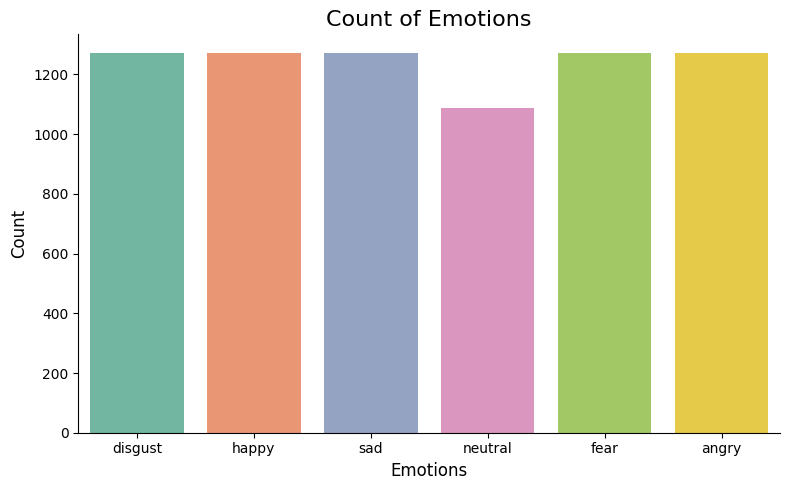

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
plt.title('Count of Emotions', size=16)

sns.countplot(x=df['emotion_label'], palette='Set2')

plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.tight_layout()

plt.show()


In [12]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(data, sr=sr)
    plt.title(f'Waveplot - {emotion}', size=14)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def create_spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(f'Spectrogram - {emotion}', size=14)
    plt.tight_layout()
    plt.show()


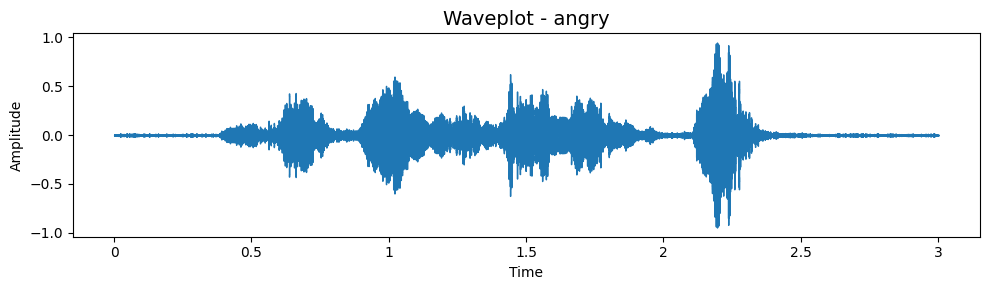

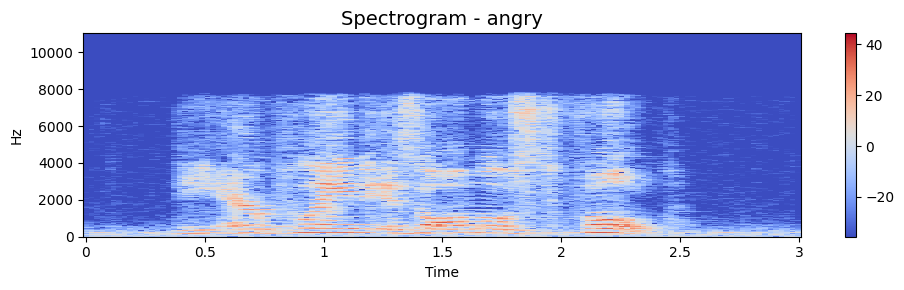

In [13]:
# Set target emotion
emotion = 'angry'  # Options: sad, happy, disgust, fear, angry, neutral

# Get first audio path for selected emotion
path = df[df['emotion_label'] == emotion]['file_path'].values[0]

# Load audio
data, sampling_rate = librosa.load(path)

# Create plots
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# Play audio
Audio(path)

🔊 Emotion: disgust


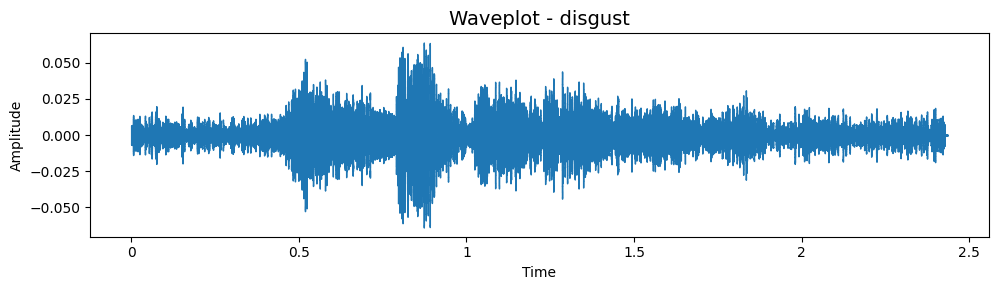

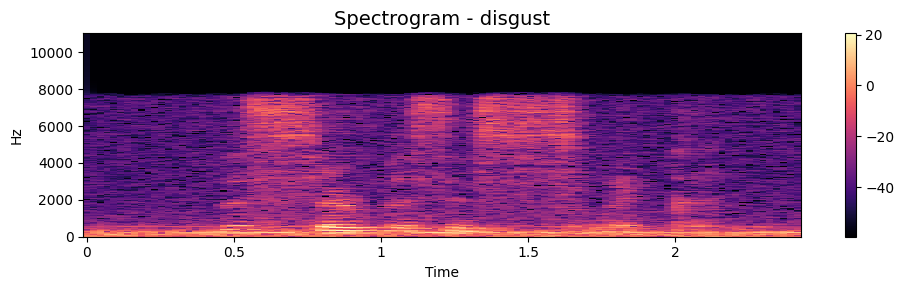

🔊 Emotion: happy


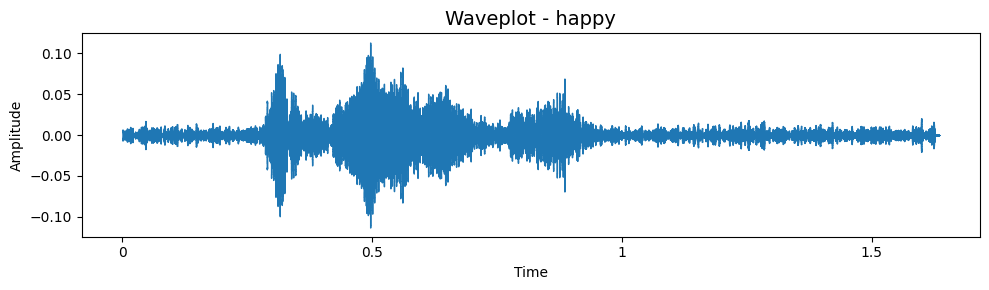

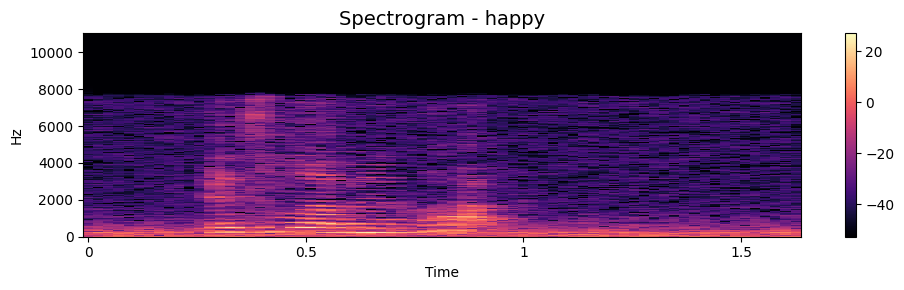

🔊 Emotion: sad


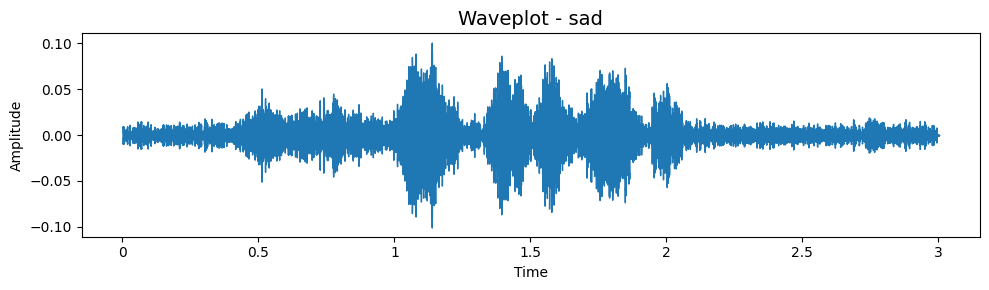

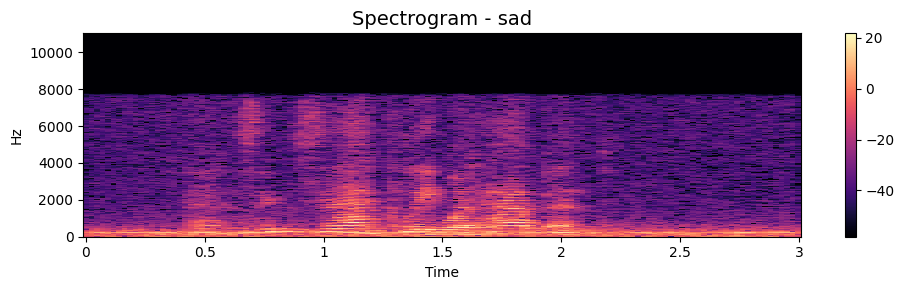

🔊 Emotion: neutral


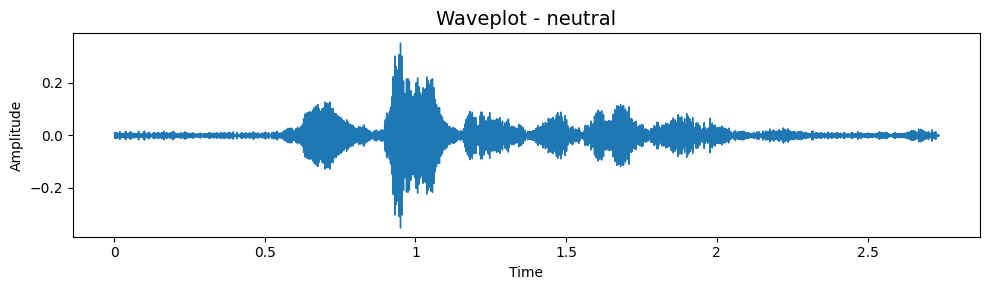

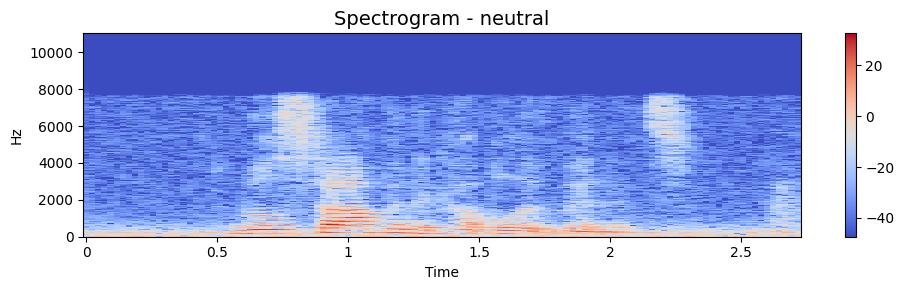

🔊 Emotion: fear


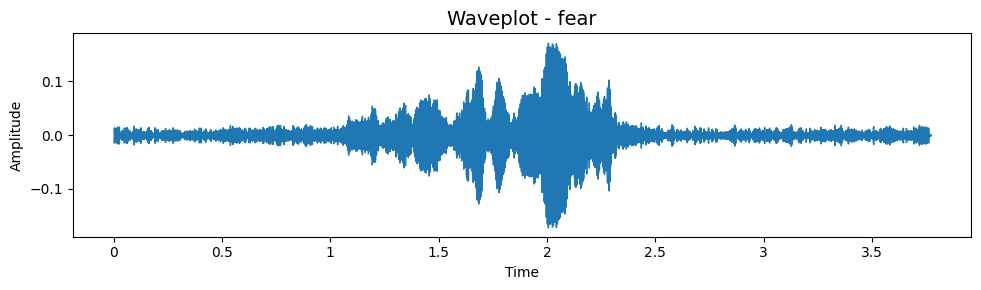

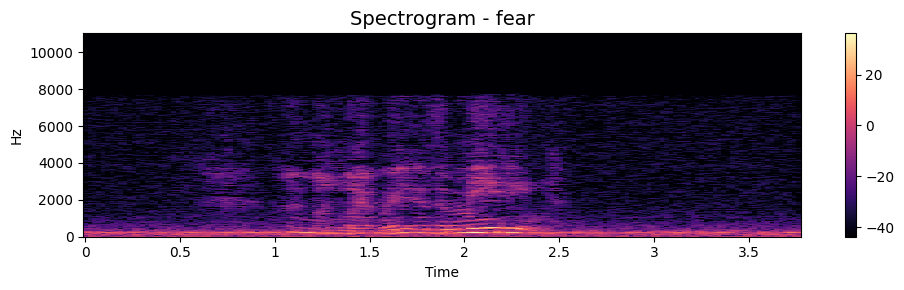

🔊 Emotion: angry


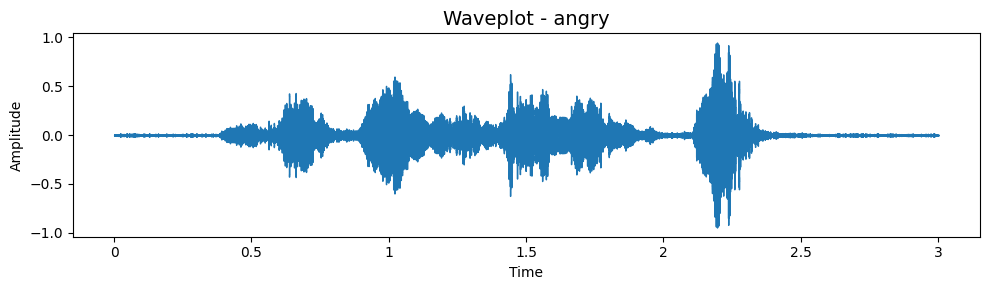

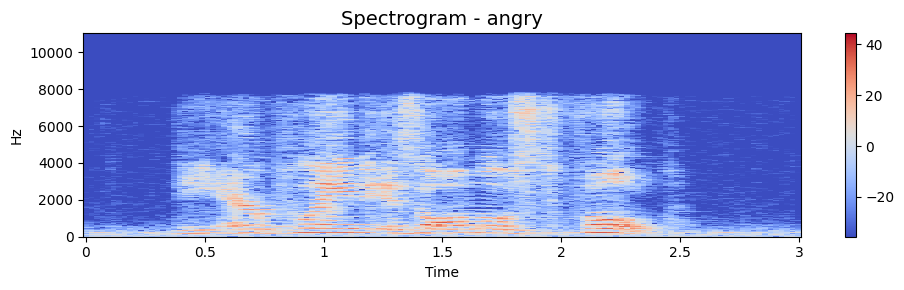

In [14]:
emotions = df['emotion_label'].unique()

for emotion in emotions:
    path = df[df['emotion_label'] == emotion]['file_path'].values[0]
    data, sr = librosa.load(path)
    print(f"🔊 Emotion: {emotion}")
    create_waveplot(data, sr, emotion)
    create_spectrogram(data, sr, emotion)
    display(Audio(path))

In [15]:
import librosa
import numpy as np
from tqdm import tqdm

valid_labels = ['happy', 'angry', 'fear', 'sad', 'disgust', 'neutral']
max_len = 300
X = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        label = row['emotion_label']
        if label not in valid_labels:
            continue

        signal, sr = librosa.load(row['file_path'], sr=22050)
        signal = signal / (np.max(np.abs(signal)) + 1e-7)  # Normalize volume

        # Extract features
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13).T              # (T, 13)
        chroma = librosa.feature.chroma_stft(y=signal, sr=sr).T                # (T, 12)
        mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel).T                                    # (T, 128)
        zcr = librosa.feature.zero_crossing_rate(y=signal).T                   # (T, 1)


        def pad(x):
            return np.pad(x, ((0, max_len - x.shape[0]), (0, 0)), mode='constant') if x.shape[0] < max_len else x[:max_len, :]

        mfcc = pad(mfcc)
        chroma = pad(chroma)
        mel_db = pad(mel_db)
        zcr = pad(zcr)


        combined = np.concatenate((mfcc, chroma, mel_db, zcr), axis=1)
        X.append(combined)
        y.append(label)

    except Exception as e:
        print(f"Error with {row['filename']}: {e}")

X = np.array(X)
y = np.array(y)
print("Feature shape:", X.shape)


100%|██████████| 7442/7442 [05:51<00:00, 21.15it/s]


Feature shape: (7442, 300, 154)


In [16]:
print(X[0])

[[-2.26319717e+02  1.20133591e+02  2.97535324e+01 ... -4.11766739e+01
  -4.12093163e+01  1.12304688e-02]
 [-2.15944809e+02  1.33866440e+02  2.92481842e+01 ... -4.72214165e+01
  -4.72536659e+01  1.75781250e-02]
 [-2.22505661e+02  1.37686493e+02  3.64958649e+01 ... -4.82207794e+01
  -4.82207794e+01  2.34375000e-02]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [17]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)

print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Class mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded
)

In [19]:
X_train[0]

array([[-3.13310486e+02,  1.30495758e+02,  2.75206966e+01, ...,
        -4.99217758e+01, -4.99569130e+01,  5.37109375e-03],
       [-2.89408691e+02,  1.37901230e+02,  2.59613342e+01, ...,
        -5.00998001e+01, -5.00998001e+01,  8.78906250e-03],
       [-2.92786041e+02,  1.31681763e+02,  3.47370033e+01, ...,
        -5.00998001e+01, -5.00998001e+01,  1.51367188e-02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [20]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.9758720167846839, 1: 0.9758720167846839, 2: 0.9758720167846839, 3: 0.9758720167846839, 4: 1.1410610242256976, 5: 0.9758720167846839}


In [21]:
X_train

array([[[-3.13310486e+02,  1.30495758e+02,  2.75206966e+01, ...,
         -4.99217758e+01, -4.99569130e+01,  5.37109375e-03],
        [-2.89408691e+02,  1.37901230e+02,  2.59613342e+01, ...,
         -5.00998001e+01, -5.00998001e+01,  8.78906250e-03],
        [-2.92786041e+02,  1.31681763e+02,  3.47370033e+01, ...,
         -5.00998001e+01, -5.00998001e+01,  1.51367188e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-2.84949066e+02,  1.26371796e+02,  3.34639549e+01, ...,
         -4.63905144e+01, -4.64186859e+01,  1.17187500e-02],
        [-2.85377289e+02,  1.37437454e+02,  2.78264332e+01, ...,
         -5.24379196e+01, -5.24655876e

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(5953, 300, 154)
(1489, 300, 154)
(1489, 6)
(5953, 6)


In [23]:
# Show the first training sample
print("Train sample 1:")
print(X_train[0])
print("Label:", y_train[0])

# Show the first testing sample
print("\nTest sample 1:")
print(X_test[0])
print("Label:", y_test[0])

Train sample 1:
[[-3.13310486e+02  1.30495758e+02  2.75206966e+01 ... -4.99217758e+01
  -4.99569130e+01  5.37109375e-03]
 [-2.89408691e+02  1.37901230e+02  2.59613342e+01 ... -5.00998001e+01
  -5.00998001e+01  8.78906250e-03]
 [-2.92786041e+02  1.31681763e+02  3.47370033e+01 ... -5.00998001e+01
  -5.00998001e+01  1.51367188e-02]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Label: [0. 0. 0. 0. 1. 0.]

Test sample 1:
[[-4.40432831e+02  6.18224716e+01  5.19879684e+01 ... -4.30233231e+01
  -4.30233231e+01  1.41601562e-02]
 [-4.31649658e+02  7.17967224e+01  5.63582230e+01 ... -4.30233231e+01
  -4.30233231e+01  2.68554688e-02]
 [-4.33172546e+02  7.02131653e+01  5.58502045e+01 ... -4.30233231e+01
  -4.30233231e+01  3.3691

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [25]:
from tensorflow.keras.losses import CategoricalCrossentropy

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam


# CNN + BiLSTM with moderate depth
model = Sequential()

model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(300, 154),kernel_regularizer=l2(0.00001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(128, kernel_size=3, activation='relu',kernel_regularizer=l2(0.00001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64,return_sequences=True))) #change
model.add(Bidirectional(LSTM(32))) 
# Second layer
model.add(BatchNormalization())   #change


model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.compile(
    optimizer=Nadam(learning_rate=0.0005),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


model.summary()



I0000 00:00:1752810651.989263      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752810651.989971      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 298, 64)        │        29,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 298, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 149, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 149, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 147, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 147, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 73, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 73, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 73, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,942 (781.02 KB)

 Trainable params: 199,430 (779.02 KB)

 Non-trainable params: 512 (2.00 KB)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,verbose=1)

In [28]:
history = model.fit(
    X_train, y_train, #change  X_train,y_train
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/50


I0000 00:00:1752810670.585265     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.2633 - loss: 1.8232 - val_accuracy: 0.3922 - val_loss: 1.5703 - learning_rate: 5.0000e-04
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3745 - loss: 1.6027 - val_accuracy: 0.4345 - val_loss: 1.4858 - learning_rate: 5.0000e-04
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4128 - loss: 1.5230 - val_accuracy: 0.4782 - val_loss: 1.4355 - learning_rate: 5.0000e-04
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4665 - loss: 1.4453 - val_accuracy: 0.4849 - val_loss: 1.3900 - learning_rate: 5.0000e-04
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4812 - loss: 1.4194 - val_accuracy: 0.3895 - val_loss: 1.7807 - learning_rate: 5.0000e-04
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5289 - loss: 1.3625 - val_accuracy: 0.5030 - val_loss: 1.3938 - learning_rate: 5.0000e-04
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5

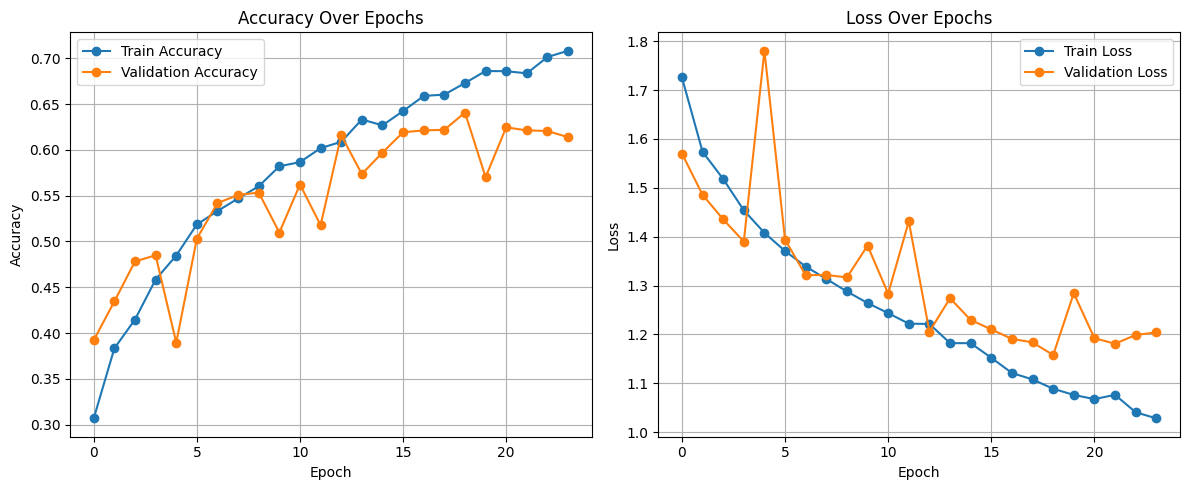

In [29]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", test_accuracy)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Test Accuracy: 0.6406984553391538


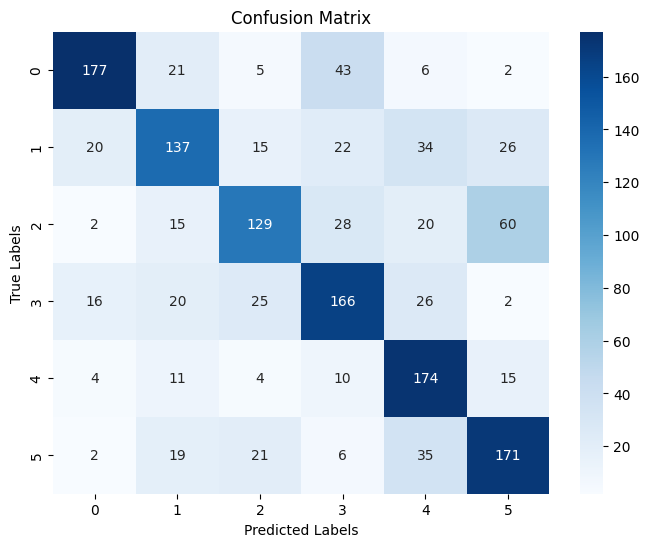

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [32]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.70      0.75       254
           1       0.61      0.54      0.57       254
           2       0.65      0.51      0.57       254
           3       0.60      0.65      0.63       255
           4       0.59      0.80      0.68       218
           5       0.62      0.67      0.65       254

    accuracy                           0.64      1489
   macro avg       0.65      0.64      0.64      1489
weighted avg       0.65      0.64      0.64      1489



In [37]:
model.save("model_cnn_bilstm.h5")  # Save model in HDF5 format
print("Model saved as 'model_cnn_bilstm.h5'")


Model saved as 'model_cnn_bilstm.h5'


In [38]:
import zipfile

with zipfile.ZipFile("model.zip", "w") as zipf:
    zipf.write("model_cnn_bilstm.h5")


In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
report = classification_report(y_true_labels, y_pred_labels)

# Save as CSV
pd.DataFrame(conf_matrix).to_csv("confusion_matrix.csv", index=False)
with open("classification_report.txt", "w") as f:
    f.write(report)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [40]:
# Example: Random test sample from your test set
sample = X_test[0]  # shape: (300, 154)

# Reshape to match model's expected input: (1, 300, 154)
sample = np.expand_dims(sample, axis=0)

# Predict
prediction = model.predict(sample)

# Get the predicted class
predicted_class = np.argmax(prediction, axis=1)

print("Predicted Class:", predicted_class[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Class: 0


In [41]:
# Class mapping
class_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
index_to_class = {v: k for k, v in class_mapping.items()}  # Reverse mapping

# Pick a sample from test data
sample = X_test[1]  # shape (300, 154)
sample = np.expand_dims(sample, axis=0)  # shape becomes (1, 300, 154)

# Make prediction
prediction = model.predict(sample)
predicted_class_index = np.argmax(prediction, axis=1)[0]

# Get class name
predicted_class_name = index_to_class[predicted_class_index]

# Output
print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Name:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Class Index: 3
Predicted Class Name: happy


In [51]:
import numpy as np

# Class mapping
class_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
index_to_class = {v: k for k, v in class_mapping.items()}

# Sample index from test set
sample_index = 0

# Select sample
sample = X_test[sample_index]  # shape (300, 154)
sample = np.expand_dims(sample, axis=0)  # shape becomes (1, 300, 154)

# Make prediction
prediction = model.predict(sample)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class_name = index_to_class[predicted_class_index]

# Get true label
true_label_index = y_test[sample_index]
if isinstance(true_label_index, np.ndarray):  # If one-hot encoded
    true_label_index = np.argmax(true_label_index)

true_class_name = index_to_class[true_label_index]

# Output
print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Name:", predicted_class_name)
print("Actual Class Index:", true_label_index)
print("Actual Class Name:", true_class_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Class Index: 0
Predicted Class Name: angry
Actual Class Index: 0
Actual Class Name: angry


In [50]:
import numpy as np

# Class mapping
class_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
index_to_class = {v: k for k, v in class_mapping.items()}

# Sample index from test set
sample_index = 1

# Select sample
sample = X_test[sample_index]  # shape (300, 154)
sample = np.expand_dims(sample, axis=0)  # shape becomes (1, 300, 154)

# Make prediction
prediction = model.predict(sample)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class_name = index_to_class[predicted_class_index]

# Get true label
true_label_index = y_test[sample_index]
if isinstance(true_label_index, np.ndarray):  # If one-hot encoded
    true_label_index = np.argmax(true_label_index)

true_class_name = index_to_class[true_label_index]

# Output
print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Name:", predicted_class_name)
print("Actual Class Index:", true_label_index)
print("Actual Class Name:", true_class_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Class Index: 3
Predicted Class Name: happy
Actual Class Index: 3
Actual Class Name: happy


In [49]:
import numpy as np

# Class mapping
class_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
index_to_class = {v: k for k, v in class_mapping.items()}

# Sample index from test set
sample_index = 5

# Select sample
sample = X_test[sample_index]  # shape (300, 154)
sample = np.expand_dims(sample, axis=0)  # shape becomes (1, 300, 154)

# Make prediction
prediction = model.predict(sample)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class_name = index_to_class[predicted_class_index]

# Get true label
true_label_index = y_test[sample_index]
if isinstance(true_label_index, np.ndarray):  # If one-hot encoded
    true_label_index = np.argmax(true_label_index)

true_class_name = index_to_class[true_label_index]

# Output
print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Name:", predicted_class_name)
print("Actual Class Index:", true_label_index)
print("Actual Class Name:", true_class_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Class Index: 5
Predicted Class Name: sad
Actual Class Index: 5
Actual Class Name: sad


In [48]:
import numpy as np

# Class mapping
class_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
index_to_class = {v: k for k, v in class_mapping.items()}

# Sample index from test set
sample_index = 10

# Select sample
sample = X_test[sample_index]  # shape (300, 154)
sample = np.expand_dims(sample, axis=0)  # shape becomes (1, 300, 154)

# Make prediction
prediction = model.predict(sample)
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class_name = index_to_class[predicted_class_index]

# Get true label
true_label_index = y_test[sample_index]
if isinstance(true_label_index, np.ndarray):  # If one-hot encoded
    true_label_index = np.argmax(true_label_index)

true_class_name = index_to_class[true_label_index]

# Output
print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Name:", predicted_class_name)
print("Actual Class Index:", true_label_index)
print("Actual Class Name:", true_class_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Class Index: 0
Predicted Class Name: angry
Actual Class Index: 0
Actual Class Name: angry


In [67]:
# Class mapping
class_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
index_to_class = {v: k for k, v in class_mapping.items()}  # Reverse mapping

# Pick a sample from test data
sample = X_train[1]  # shape (300, 154)
sample = np.expand_dims(sample, axis=0)  # shape becomes (1, 300, 154)

# Make prediction
prediction = model.predict(sample)
predicted_class_index = np.argmax(prediction, axis=1)[0]

# Get class name
predicted_class_name = index_to_class[predicted_class_index]

# Output
print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Name:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Class Index: 5
Predicted Class Name: sad


In [66]:
import pickle

# Example: Saving a scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
